In [75]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from copy import deepcopy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from bokeh.plotting import output_file, output_notebook, figure, show
import os
os.chdir('/home/mfc/Dropbox/spring2016/dataMining/projects/project3/')
from sys import stderr, stdout
from CART.cart2 import *
import pickle
from scipy.stats.mstats import mode

# dividing the data into training, validation and testing parts , 5000 each. 
## poker hand dataset (https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

In [2]:
col_name = ['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5', 'label']
df = pd.read_csv('data/poker-hand-training-true.data.txt', names=col_name)
train_data = df[:5000]
valid_data = df[5001:10000]
test_data = df[10001:15000]

# histogram. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0be5c71d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0be370d080>]], dtype=object)

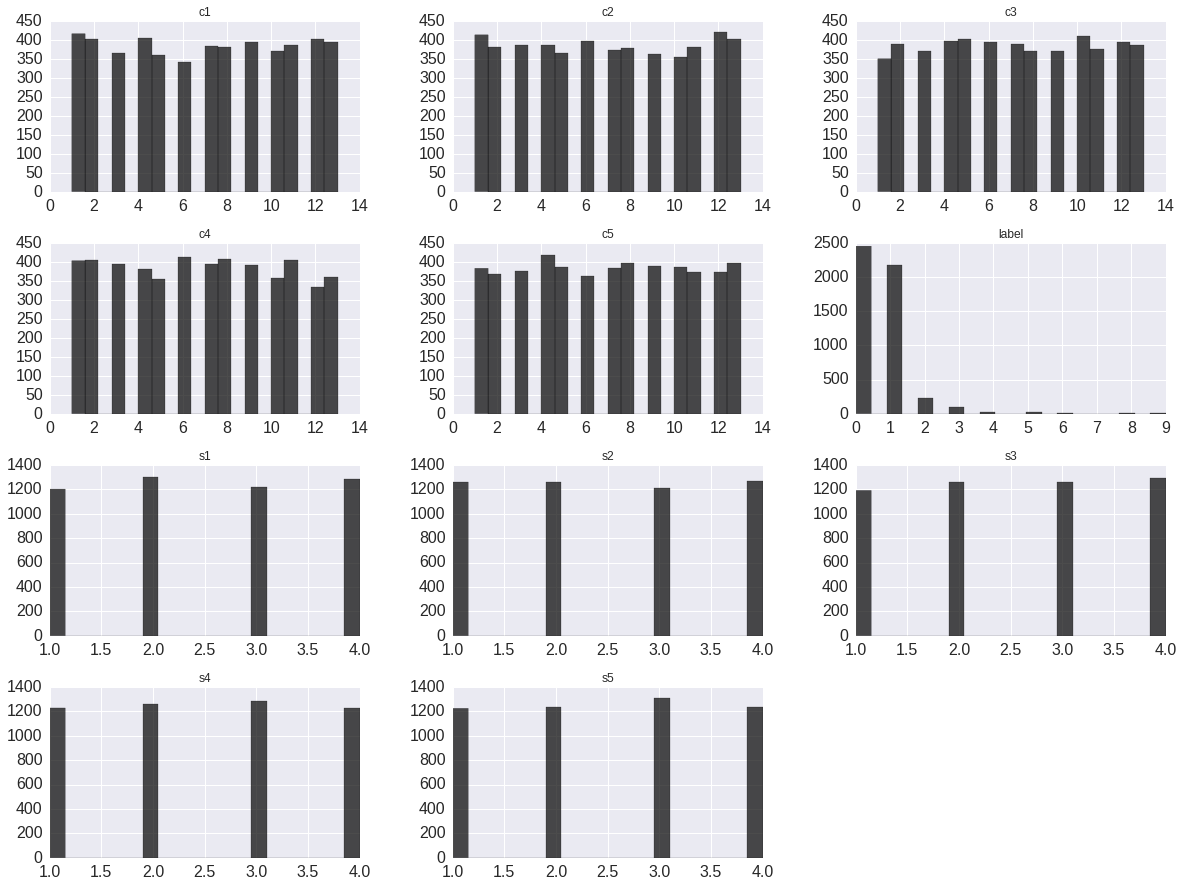

In [3]:
train_data.ix[:,:11].hist(color='k', alpha=0.7, figsize=(20,15), bins=20, xlabelsize=16, ylabelsize=16)

# growing the tree on the traning data. using entropy impurity function.

In [107]:
new = 0
if new:
    my_tree = growDecisionTreeFrom(train_data.values.tolist(), evaluationFunction=gini)
    with open('model.pkl','wb') as f:
        pickle.dump(my_tree, f)
else: 
    with open('model.pkl','rb') as f:
        my_tree = pickle.load(f)
print("finished")

finished


# drawing the tree diagram.

In [ ]:
with open('original.tree.txt','w') as f:
    f.write(plot(my_tree, column_name=col_name))
try:
    drawtree(my_tree, jpeg='original.tree.jpeg', column_name=col_name)
except:
    print('Failed to save tree plot')
print("finished")

# draw original tree. (it's too large to see the whole thing, need to zoom in)

![tree](../doc/tree.jpg)

# pruning the tree using minimum gain criteria. find the the best minimum gain value using classification error rate on validation dataset

In [4]:
def validation(df, tree, minGain = None, evaluationFunction=gini):
    error = {}
    for i in mingain:
        prediction = []
        this_tree = deepcopy(tree)
        try:
            prune(this_tree, minGain=i, evaluationFunction=evaluationFunction)
        except:
            print('mingGain:', i)
            continue
        for obs in df.values.tolist():
            obs_pred = classify(obs, this_tree)
            prediction.append(max(obs_pred, key=obs_pred.get))
        comp_class = map(lambda x: x[0] == x[1], zip(prediction, df.label.values.tolist()))
        error_rate = 1 - (sum(comp_class) / len(df.label))
        error[i] = error_rate
    print('finished')
    best_value = min(error, key=error.get)
    new_tree = deepcopy(tree)
    prune(new_tree, minGain=best_value, evaluationFunction=evaluationFunction)
    return new_tree, error

# pruned the tree with the best value  obtained above

In [109]:
mingain = np.linspace(0.01, 5, 200)
this_tree, error = validation(valid_data, my_tree, minGain=mingain, evaluationFunction=gini)

finished


# draw the pruned tree

In [ ]:
with open('pruned.tree.txt','w') as f:
    f.write(plot(this_tree, column_name=col_name))
try:
    drawtree(this_tree, jpeg='./doc/second.tree.jpeg', column_name=col_name)
except:
    print('Failed to save tree plot')

# the number on each node is (class label: number of observation in that node)
![pruned tree](../doc/second.tree.jpeg)

# classification error rate on test data set

In [110]:
def test_error(tree, df):
    prediction = []
    for obs in df.values.tolist():
        obs_pred = classify(obs, tree)
        prediction.append(max(obs_pred, key=obs_pred.get))
        comp_class = map(lambda x: x[0] == x[1], zip(prediction, df.label.values.tolist()))
        error_rate = 1 - (sum(comp_class) / len(df.label))
    return prediction, error_rate
    
pred, error_rate = test_error(this_tree, test_data)
error_rate

0.4738522954091816

# bagging

In [114]:
col_name = ['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5', 'label']
df = pd.read_csv('data/poker-hand-training-true.data.txt', names=col_name)
train_data = df[:15000]
valid_data = df[15001:20000]
test_data = df[20000:]

new = 1
if new:
    trees = []
    pruned_tree = []
    mingain = np.linspace(0.01, 5, 200)
    num_trees = 20

    for i in range(num_trees):
        sample = train_data.sample(1000)
        trees.append(growDecisionTreeFrom(sample.values.tolist(), evaluationFunction=gini))
        pruned_tree.append(validation(valid_data, trees[i], minGain=mingain, evaluationFunction=gini))
        print('tree:', i)
    with open('bagged_2.pkl','wb') as f:
        pickle.dump({"trees":trees, "pruned_trees": pruned_tree}, f)

else: 
    with open('bagged_2.pkl','rb') as f:
        bagged_data = pickle.load(f)
    pruned_tree = bagged_data['pruned_trees']

predictions = []
error = {}
for i, tree in enumerate(pruned_tree):
    try:
        pred, error[i] = test_error(tree[0], test_data)
        predictions.append(pred)
    except:
        print("tree %d failed" % i)
        pass

finished
tree: 0
finished
tree: 1
finished
tree: 2
finished
tree: 3
finished
tree: 4
finished
tree: 5
finished
tree: 6
finished
tree: 7
finished
tree: 8
finished
tree: 9
finished
tree: 10
finished
tree: 11
finished
tree: 12
finished
tree: 13
finished
tree: 14
finished
tree: 15
finished
tree: 16
finished
tree: 17
finished
tree: 18
finished
tree: 19


# calculate mean vote from different trees prediction and find error rate

In [140]:
mean_vote = []
for row in np.array(predictions).T:
    row = row.tolist()
    mean_vote.append(max(set(row)))#, key=row.count))
    
    
comp_class = map(lambda x: x[0] == x[1], zip(mean_vote, test_data.label.values.tolist()))
error_rate = 1 - (sum(comp_class) / len(test_data.label))
error_rate 

0.4868263473053892

In [142]:
plot(pruned_tree[15][0], col_name)

'Column s4: x >= 3?\nyes -> Column c2: x >= 10?\n\t\tyes -> Column c3: x >= 11?\n\t\t\t\tyes -> {0: 12, 1: 15, 2: 2, 3: 2, 4: 3, 9: 1}\n\t\t\t\tno  -> {0: 74, 1: 55, 2: 7, 4: 1, 5: 2}\n\t\tno  -> {0: 165, 1: 138, 2: 19, 3: 5, 5: 1}\nno  -> Column c4: x >= 12?\n\t\tyes -> Column s1: x >= 3?\n\t\t\t\tyes -> {0: 24, 1: 12, 7: 1}\n\t\t\t\tno  -> {0: 13, 1: 11, 2: 2, 3: 2}\n\t\tno  -> {0: 223, 1: 182, 2: 19, 3: 9}'